### Preparing the data

In [5]:
# check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bd9c05c6-08a0-b26b-9cd6-747fb4b21662)
GPU 1: Tesla T4 (UUID: GPU-514d2d6c-57d0-d20e-a95a-44a80a63ebef)


In [6]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [7]:
# checking the version of tensorflow
print(tf.__version__)

2.6.4


In [8]:
# setting the random seeds for reproducibility of results
np.random.seed(7)
tf.random.set_seed(7)

import random
random.seed(7)

In [9]:
# data month by month
periods = pd.read_csv('/kaggle/input/consumer-price-index/cu.period.csv', index_col='period')

# contains type of indices and description
items = pd.read_csv('/kaggle/input/consumer-price-index/cu.item.csv')

# CPI values for food and beverages
fnb = pd.read_csv('/kaggle/input/consumer-price-index/cu.data.14.USTransportation.csv')

In [10]:
fnb.drop('footnote_codes', axis=1, inplace=True)
fnb.series_id = [i[8:] for i in fnb.series_id]

In [11]:
items.head()

,item_code,item_name,display_level,selectable,sort_sequence
0,AA0,All items - old base,0.0,T,2.0
1,AA0R,Purchasing power of the consumer dollar - old ...,0.0,T,399.0
2,SA0,All items,0.0,T,1.0
3,SA0E,Energy,1.0,T,374.0
4,SA0L1,All items less food,1.0,T,358.0


In [12]:
fnb.head()

,series_id,year,period,value
0,SAT,1947,M01,17.9
1,SAT,1947,M02,17.9
2,SAT,1947,M03,18.1
3,SAT,1947,M04,18.3
4,SAT,1947,M05,18.3


In [13]:
c = np.array([[c, items.loc[items['item_code'] == c]['item_name'].values[0]] for c in fnb.series_id.unique()])
c = pd.DataFrame(c[:, 1], columns=['Stands for'], index=c[:,0])

In [14]:
c

,Stands for
SAT,Transportation
SAT1,Private transportation
SATCLTB,Transportation commodities less motor fuel
SETA,New and used motor vehicles
SETA01,New vehicles
SETA02,Used cars and trucks
SETA03,Leased cars and trucks
SETA04,Car and truck rental
SETB,Motor fuel
SETB01,Gasoline (all types)


In [15]:
# merge year and period to use it as x on plots
fnb_m = fnb[fnb['period'].isin(periods.index[:12])].copy()
fnb_m.period = fnb_m.period.str.split('M').str[1]
fnb_m.year = fnb_m.year.astype(str)
fnb_m.year = fnb_m.year + '-' + fnb_m.period
fnb_m.drop('period', axis=1, inplace=True)
fnb_m.year = pd.to_datetime(fnb_m.year)

print(fnb_m.shape)
fnb_m.head()

(28946, 3)


,series_id,year,value
0,SAT,1947-01-01,17.9
1,SAT,1947-02-01,17.9
2,SAT,1947-03-01,18.1
3,SAT,1947-04-01,18.3
4,SAT,1947-05-01,18.3


# Considering the CPI values for Food

In [19]:
# Consider the values for food
df = fnb_m.loc[fnb_m['series_id'] == 'SAT']
df = df.rename(columns={'year':'date'})
df.drop(['series_id'], axis=1, inplace=True)

# sort the values as they may not always be continuous
df.sort_values(by='date', inplace=True)

print(df.shape)
df.head()

(1738, 2)


,date,value
11352,1935-03-01,14.2
11353,1935-07-01,14.3
11354,1935-10-01,14.1
11356,1936-01-01,14.1
11357,1936-04-01,14.3


In [20]:
X = df['date']
y = df['value']

split_size = int(0.8 * len(X))

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(1390, 348, 1390, 348)

In [21]:
# function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Date")
  plt.ylabel("Value")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

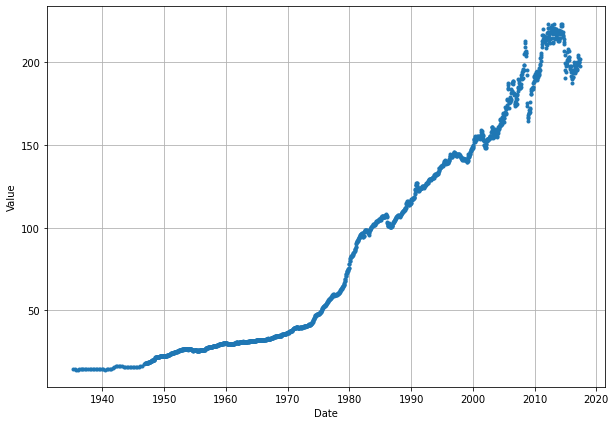

In [22]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=df['date'], values=df['value'])

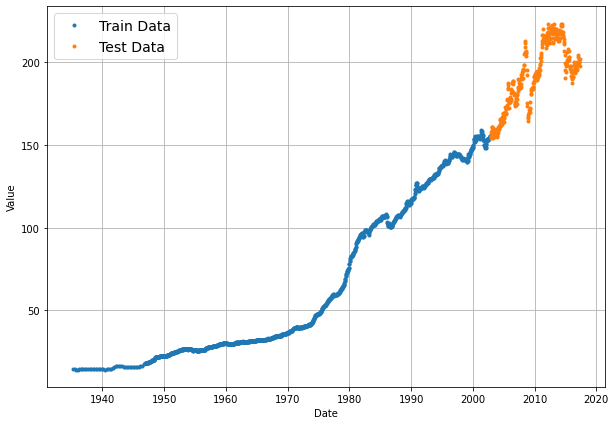

In [23]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train Data')
plot_time_series(timesteps=X_test, values=y_test, label='Test Data')

In [24]:
X_train.max()

Timestamp('2002-11-01 00:00:00')

### Windowing the data

In [25]:
# function for getting the labelled windows
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

WINDOW = 8
HORIZON = 1

In [26]:
values = df['value'].to_numpy();

In [27]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1730, 1730)

In [28]:
for i in range(5):
  print(f"Window: {windows[i]} -> Label: {labels[i]}")

Window: [14.2 14.3 14.1 14.1 14.3 14.3 14.3 14.3] -> Label: [14.5]
Window: [14.3 14.1 14.1 14.3 14.3 14.3 14.3 14.5] -> Label: [14.5]
Window: [14.1 14.1 14.3 14.3 14.3 14.3 14.5 14.5] -> Label: [14.6]
Window: [14.1 14.3 14.3 14.3 14.3 14.5 14.5 14.6] -> Label: [14.7]
Window: [14.3 14.3 14.3 14.3 14.5 14.5 14.6 14.7] -> Label: [14.7]


### Train Test Splitting the Windows

In [29]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [30]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1384, 346, 1384, 346)

### Function for evaluating the models

In [31]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae/mae_naive_no_season

# function for evaluating timeseries prediction
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
    'mae': mae.numpy(),
    'mse': mse.numpy(),
    'rmse': rmse.numpy(),
    'mape': mape.numpy(),
    'mase': mase.numpy()
  }

### Function for making forecasts with a model

In [32]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

### Creating a modelling checkpoint for saving the best model

In [33]:
import os

def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(save_path, model_name),
    verbose=0,
    save_best_only=True
  )

# Create a function for making dense models with given window and horizon sizes

In [34]:
# function that creates and compiles a dense model with the given window and horizon sizes
def make_dense_model(window_size=7, horizon_size=1, model_name='dense'):
  # setting random seed for reproducible results
  tf.random.set_seed(7)
  np.random.seed(7)

  # create the model
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(horizon_size, activation='linear')
  ], name=model_name)

  # compile the model
  model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae']
  )
  
  # return the model
  return model


## Dense Model (window=8, horizon=1)

In [35]:
WINDOW = 8
HORIZON = 1

In [36]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [37]:
# make the model
dense_window_8_horizon_1 = make_dense_model(window_size=8, horizon_size=1, model_name='dense_window_8_horizon_1')

# fit the model
dense_window_8_horizon_1_history = dense_window_8_horizon_1.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_8_horizon_1.name)]
)

2022-11-27 09:08:02.078526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:08:02.079509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:08:02.212034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:08:02.212966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 09:08:02.213804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Epoch 1/100
11/11 [==============================] - 2s 17ms/step - loss: 79.7761 - mae: 79.7761 - val_loss: 134.7919 - val_mae: 134.7919


2022-11-27 09:08:08.054984: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 24.5785 - mae: 24.5785 - val_loss: 12.8638 - val_mae: 12.8638
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 8.7845 - mae: 8.7845 - val_loss: 6.3994 - val_mae: 6.3994
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 2.8414 - mae: 2.8414 - val_loss: 6.8397 - val_mae: 6.8397
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 1.8638 - mae: 1.8638 - val_loss: 3.9040 - val_mae: 3.9040
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 1.0220 - mae: 1.0220 - val_loss: 4.3553 - val_mae: 4.3553
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8849 - mae: 0.8849 - val_loss: 4.1709 - val_mae: 4.1709
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7506 - mae: 0.7506 - val_loss: 4.0502 - val_mae: 4.0502
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6427

In [38]:
# load the best performing model from the model checkpoint
dense_window_8_horizon_1 = tf.keras.models.load_model("model_checkpoints/dense_window_8_horizon_1")
dense_window_8_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 3.2593 - mae: 3.2593


[3.259267807006836, 3.259267807006836]

In [39]:
dense_window_8_horizon_1_preds = make_preds(dense_window_8_horizon_1, test_windows)
len(dense_window_8_horizon_1_preds), dense_window_8_horizon_1_preds[:10]

(346,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([155.53831, 156.16713, 155.94421, 157.68059, 158.12813, 158.66502,
        160.06494, 159.46414, 160.09538, 159.38147], dtype=float32)>)

In [40]:
# make predictions using model_1
dense_window_8_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_8_horizon_1_preds
)

dense_window_8_horizon_1_results

{'mae': 3.2592678,
 'mse': 22.175447,
 'rmse': 4.709081,
 'mape': 1.7088237,
 'mase': 67.15626}

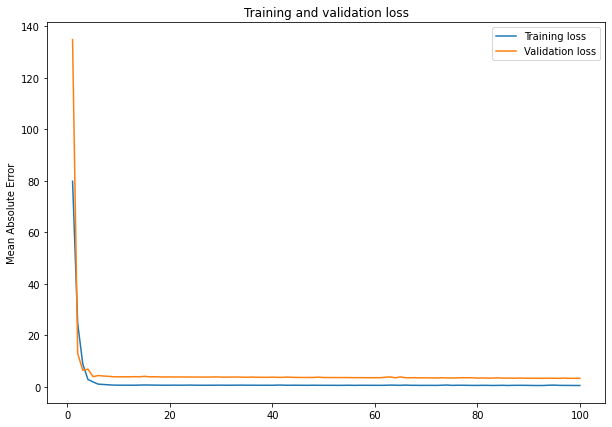

In [41]:
# visualize the loss
loss = dense_window_8_horizon_1_history.history['loss']
val_loss = dense_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

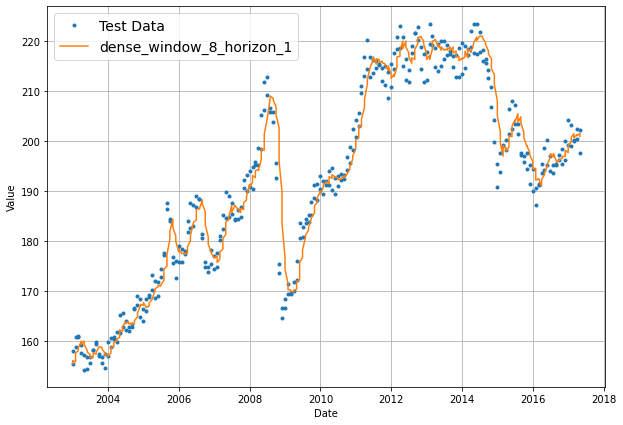

In [42]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_window_8_horizon_1_preds, format='-', label='dense_window_8_horizon_1')

## Dense Model (window=15, horizon=1)

In [43]:
WINDOW = 15
HORIZON = 1

In [44]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1723, 1723)

In [45]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1378, 345, 1378, 345)

In [46]:
# make the model
dense_window_15_horizon_1 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_15_horizon_1')

# fit the model
dense_window_15_horizon_1_history = dense_window_15_horizon_1.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_15_horizon_1.name)]
)

Epoch 1/100
11/11 [==============================] - 0s 14ms/step - loss: 49.2671 - mae: 49.2671 - val_loss: 19.7102 - val_mae: 19.7102
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 11.1098 - mae: 11.1098 - val_loss: 24.5266 - val_mae: 24.5266
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 4.8442 - mae: 4.8442 - val_loss: 4.6486 - val_mae: 4.6486
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 2.3905 - mae: 2.3905 - val_loss: 6.7297 - val_mae: 6.7297
Epoch 5/100
11/11 [==============================] - 0s 6ms/step - loss: 1.3281 - mae: 1.3281 - val_loss: 4.5213 - val_mae: 4.5213
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9852 - mae: 0.9852 - val_loss: 4.6856 - val_mae: 4.6856
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8222 - mae: 0.8222 - val_loss: 4.5100 - val_mae: 4.5100
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0

In [47]:
# load the best performing model from the model checkpoint
dense_window_15_horizon_1 = tf.keras.models.load_model("model_checkpoints/dense_window_15_horizon_1")
dense_window_15_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 3.1653 - mae: 3.1653


[3.165281057357788, 3.165281057357788]

In [48]:
dense_window_15_horizon_1_preds = make_preds(dense_window_15_horizon_1, test_windows)
len(dense_window_15_horizon_1_preds),dense_window_15_horizon_1_preds[:10]

(345,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([156.05429, 156.78273, 156.77002, 158.68507, 158.56195, 159.84476,
        159.7746 , 158.68785, 159.21365, 158.32645], dtype=float32)>)

In [49]:
dense_window_15_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=dense_window_15_horizon_1_preds
)

dense_window_15_horizon_1_results

{'mae': 3.165281,
 'mse': 21.201073,
 'rmse': 4.604462,
 'mape': 1.6626407,
 'mase': 67.16621}

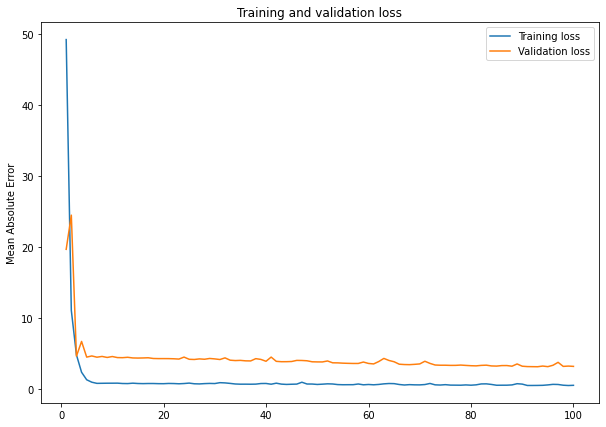

In [50]:
# visualize the loss
loss = dense_window_15_horizon_1_history.history['loss']
val_loss = dense_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

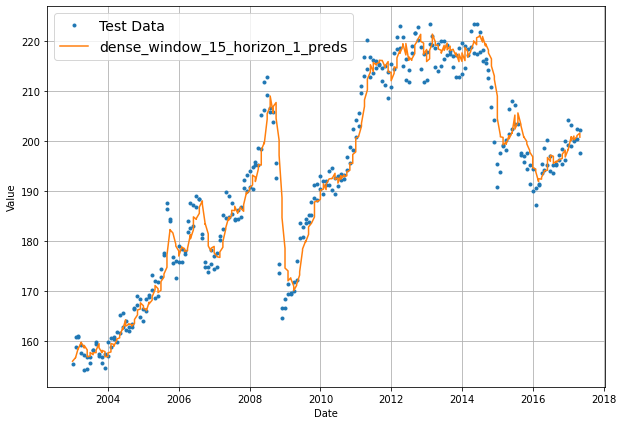

In [51]:
#visualizing the predictions
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=dense_window_15_horizon_1_preds, format='-', label='dense_window_15_horizon_1_preds')

## Dense Model (window=8, horizon=3)

In [52]:
WINDOW = 8
HORIZON = 3

In [53]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [54]:
# make the model
dense_window_8_horizon_3 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_8_horizon_3')

# fit the model
dense_window_8_horizon_3_history = dense_window_8_horizon_3.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_8_horizon_3.name)]
)

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 56.3189 - mae: 56.3189 - val_loss: 93.1252 - val_mae: 93.1252
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 18.1614 - mae: 18.1614 - val_loss: 22.5571 - val_mae: 22.5571
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 6.5435 - mae: 6.5435 - val_loss: 14.4685 - val_mae: 14.4685
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 3.2147 - mae: 3.2147 - val_loss: 7.5793 - val_mae: 7.5793
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 1.6591 - mae: 1.6591 - val_loss: 4.6145 - val_mae: 4.6145
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9932 - mae: 0.9932 - val_loss: 4.4840 - val_mae: 4.4840
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7942 - mae: 0.7942 - val_loss: 4.2896 - val_mae: 4.2896
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss:

In [55]:
# load the best performing model from the model checkpoint
dense_window_8_horizon_3 = tf.keras.models.load_model("model_checkpoints/dense_window_8_horizon_3")
dense_window_8_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 3.7651 - mae: 3.7651


[3.7651302814483643, 3.7651302814483643]

In [56]:
dense_window_8_horizon_3_preds = make_preds(dense_window_8_horizon_3, test_windows)
len(dense_window_8_horizon_3_preds), dense_window_8_horizon_3_preds[:10]

(346,
 <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[154.96216, 155.83243, 156.45721],
        [154.8581 , 155.59413, 156.37366],
        [155.11014, 155.54599, 156.41064],
        [156.06725, 156.46957, 157.0769 ],
        [156.30713, 157.0575 , 157.59862],
        [156.72069, 157.9412 , 158.23792],
        [157.40012, 159.08563, 159.19812],
        [157.95052, 159.91899, 160.24925],
        [158.7809 , 160.1621 , 160.55313],
        [159.5698 , 160.6795 , 161.27563]], dtype=float32)>)

In [57]:
# make predictions using model_1
dense_window_8_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_8_horizon_3_preds
)

dense_window_8_horizon_3_results

{'mae': 3.7651303,
 'mse': 30.72184,
 'rmse': 4.1696973,
 'mape': 1.9796973,
 'mase': 67.22925}

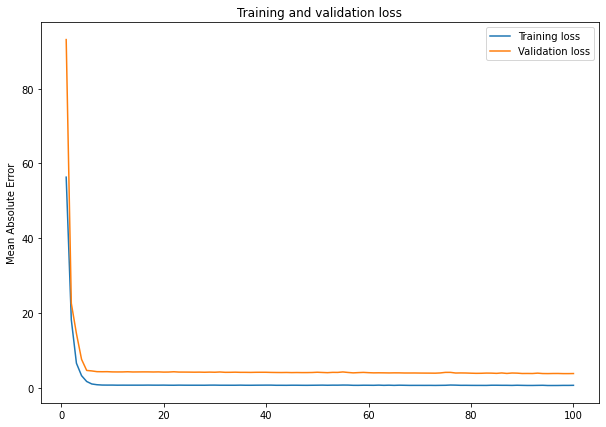

In [58]:
# visualize the loss
loss = dense_window_8_horizon_3_history.history['loss']
val_loss = dense_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

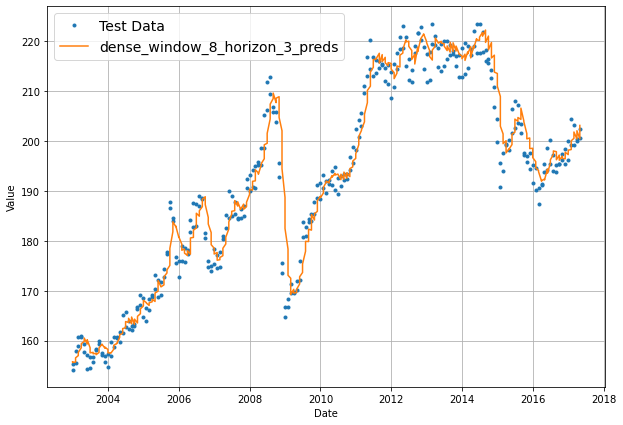

In [59]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(dense_window_8_horizon_3_preds, axis=1), format='-', label='dense_window_8_horizon_3_preds')

## Dense Model (window=15, horizon=3)

In [60]:
WINDOW = 15
HORIZON = 3

In [61]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)

In [62]:
# make the model
dense_window_15_horizon_3 = make_dense_model(window_size=WINDOW, horizon_size=HORIZON, model_name='dense_window_15_horizon_3')

# fit the model
dense_window_15_horizon_3_history = dense_window_15_horizon_3.fit(
  x=train_windows,
  y=train_labels,
  epochs=100,
  verbose=1,
  batch_size=128,
  validation_data=(test_windows,test_labels),
  callbacks=[create_model_checkpoint(model_name=dense_window_15_horizon_3.name)]
)

Epoch 1/100
11/11 [==============================] - 0s 13ms/step - loss: 30.8292 - mae: 30.8292 - val_loss: 22.8984 - val_mae: 22.8984
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 6.5585 - mae: 6.5585 - val_loss: 15.3691 - val_mae: 15.3691
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 3.3481 - mae: 3.3481 - val_loss: 8.0105 - val_mae: 8.0105
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 1.8944 - mae: 1.8944 - val_loss: 6.1324 - val_mae: 6.1324
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 1.2064 - mae: 1.2064 - val_loss: 5.3648 - val_mae: 5.3648
Epoch 6/100
11/11 [==============================] - 0s 6ms/step - loss: 0.9828 - mae: 0.9828 - val_loss: 5.2648 - val_mae: 5.2648
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9495 - mae: 0.9495 - val_loss: 5.1918 - val_mae: 5.1918
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.9

In [63]:
# load the best performing model from the model checkpoint
dense_window_15_horizon_3 = tf.keras.models.load_model("model_checkpoints/dense_window_15_horizon_3")
dense_window_15_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 4.2158 - mae: 4.2158


[4.215760707855225, 4.215760707855225]

In [64]:
dense_window_15_horizon_3_preds = make_preds(dense_window_15_horizon_3, test_windows)
len(dense_window_15_horizon_3_preds), dense_window_15_horizon_3_preds[:10]

(345,
 <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
 array([[155.04991, 154.74669, 154.8406 ],
        [154.88356, 154.54463, 155.40282],
        [155.45015, 155.80142, 156.81595],
        [155.7073 , 155.84634, 155.99794],
        [155.96552, 157.08038, 157.64128],
        [156.9179 , 158.25673, 158.06004],
        [157.11256, 158.26251, 158.61052],
        [157.72151, 159.4137 , 159.93864],
        [158.7689 , 158.85262, 159.04604],
        [158.4805 , 158.22641, 159.33797]], dtype=float32)>)

In [65]:
# make predictions using model_1
dense_window_15_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred=dense_window_15_horizon_3_preds
)

dense_window_15_horizon_3_results

{'mae': 4.2157607,
 'mse': 37.658646,
 'rmse': 4.6569395,
 'mape': 2.2233822,
 'mase': 67.21424}

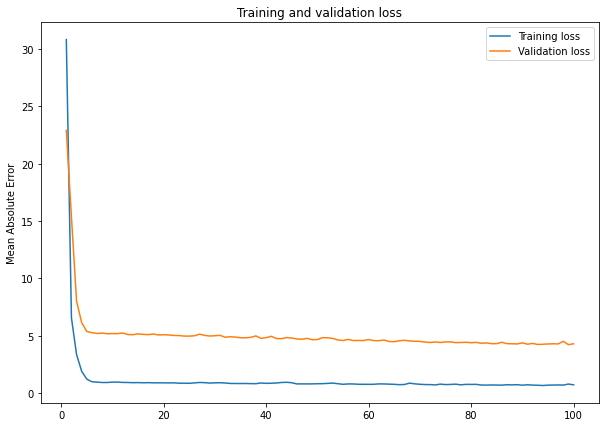

In [66]:
# visualize the loss
loss = dense_window_15_horizon_3_history.history['loss']
val_loss = dense_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

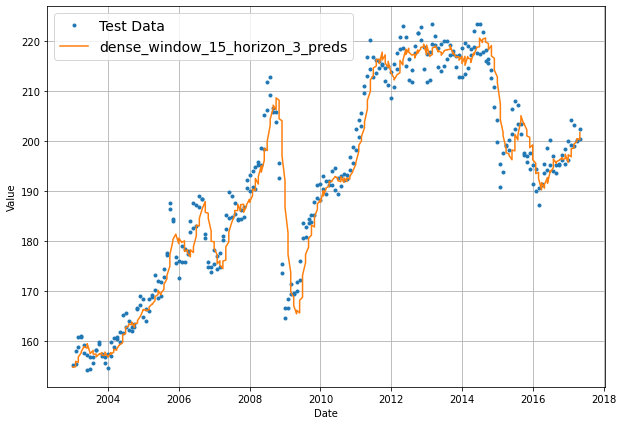

In [67]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(dense_window_15_horizon_3_preds, axis=1), format='-', label='dense_window_15_horizon_3_preds')

<AxesSubplot:>

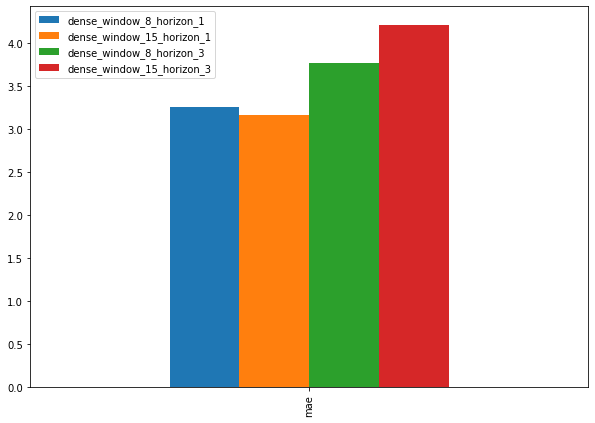

In [68]:
pd.DataFrame({
    'dense_window_8_horizon_1': dense_window_8_horizon_1_results['mae'],
    'dense_window_15_horizon_1': dense_window_15_horizon_1_results['mae'],
    'dense_window_8_horizon_3': dense_window_8_horizon_3_results['mae'],
    'dense_window_15_horizon_3': dense_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## function for creating LSTM with given window size and horizon size

In [69]:
def make_lstm_model(window_size=8, horizon_size=1, model_name='lstm'):
  tf.random.set_seed(7)
  np.random.seed(7)

  inputs = tf.keras.layers.Input(shape=(window_size))
  x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

  x = tf.keras.layers.LSTM(128, activation="relu")(x)

  output = tf.keras.layers.Dense(horizon_size)(x)

  model = tf.keras.Model(inputs=inputs, outputs=output, name=model_name)

  model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam()
  )

  return model


## LSTM (window=8, horizon=1)

In [70]:
WINDOW = 8
HORIZON = 1

In [71]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1730, 1730)

In [72]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1384, 346, 1384, 346)

In [73]:
lstm_window_8_horizon_1 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_8_horizon_1')

lstm_window_8_horizon_1_history = lstm_window_8_horizon_1.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_8_horizon_1.name)]
)

In [74]:
lstm_window_8_horizon_1 = tf.keras.models.load_model("model_checkpoints/lstm_window_8_horizon_1")
lstm_window_8_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 3.3268


3.3268160820007324

In [75]:
lstm_window_8_horizon_1_preds = make_preds(lstm_window_8_horizon_1, test_windows)
lstm_window_8_horizon_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([156.3855 , 156.863  , 156.41693, 159.33597, 157.6077 , 161.27164,
       160.60818, 160.3511 , 161.33203, 159.55602], dtype=float32)>

In [76]:
lstm_window_8_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_8_horizon_1_preds
)

lstm_window_8_horizon_1_results

{'mae': 3.3268158,
 'mse': 23.226892,
 'rmse': 4.8194284,
 'mape': 1.745869,
 'mase': 67.15626}

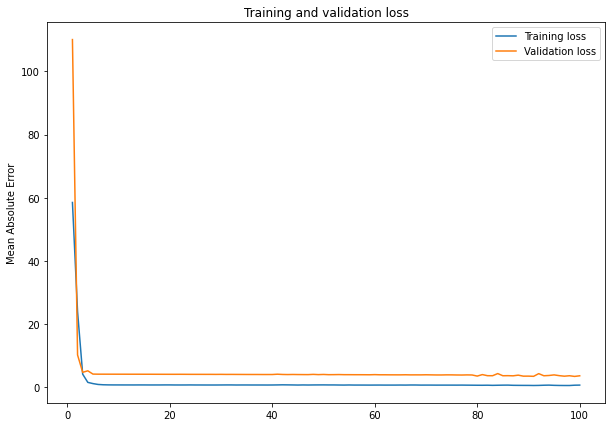

In [77]:
# visualize the loss
loss = lstm_window_8_horizon_1_history.history['loss']
val_loss = lstm_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

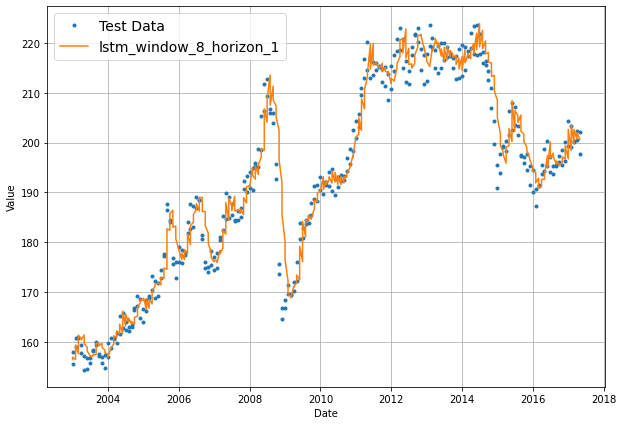

In [78]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=lstm_window_8_horizon_1_preds, format='-', label='lstm_window_8_horizon_1')

## LSTM (window=15, horizon=1)

In [79]:
WINDOW = 15
HORIZON = 1

In [80]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1723, 1723)

In [81]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1378, 345, 1378, 345)

In [82]:
lstm_window_15_horizon_1 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_15_horizon_1')

lstm_window_15_horizon_1_history = lstm_window_15_horizon_1.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_15_horizon_1.name)]
)

In [83]:
lstm_window_15_horizon_1 = tf.keras.models.load_model("model_checkpoints/lstm_window_15_horizon_1")
lstm_window_15_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 3ms/step - loss: 3.9854


3.9854094982147217

In [84]:
lstm_window_15_horizon_1_preds = make_preds(lstm_window_15_horizon_1, test_windows)
lstm_window_15_horizon_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([155.71501, 155.77687, 156.57716, 156.90161, 157.88594, 158.37169,
       158.4819 , 158.8172 , 158.70438, 158.6181 ], dtype=float32)>

In [85]:
lstm_window_15_horizon_1_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_15_horizon_1_preds
)

lstm_window_15_horizon_1_results

{'mae': 3.9854095,
 'mse': 33.939575,
 'rmse': 5.825768,
 'mape': 2.0998816,
 'mase': 67.16621}

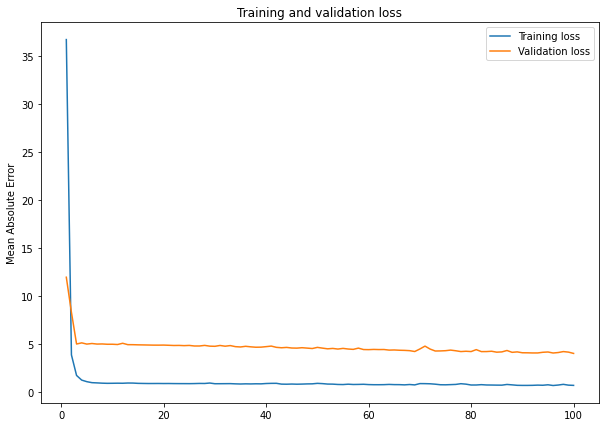

In [86]:
# visualize the loss
loss = lstm_window_15_horizon_1_history.history['loss']
val_loss = lstm_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

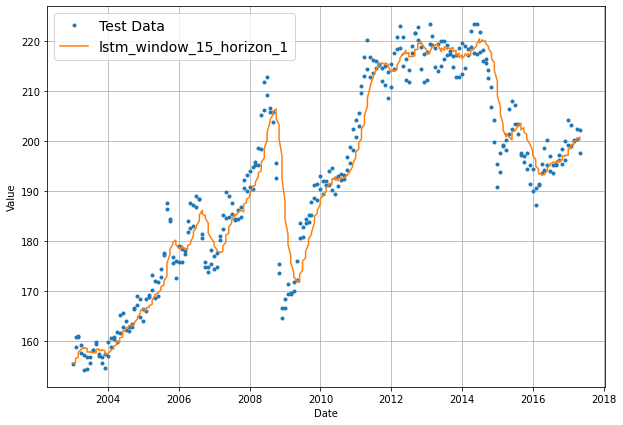

In [87]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=lstm_window_15_horizon_1_preds, format='-', label='lstm_window_15_horizon_1')

## LSTM (window=8, horizon=3)

In [88]:
WINDOW = 8
HORIZON = 3

In [89]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1728, 1728)

In [90]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1382, 346, 1382, 346)

In [91]:
lstm_window_8_horizon_3 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_8_horizon_3')

lstm_window_8_horizon_3_history = lstm_window_8_horizon_3.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_8_horizon_3.name)]
)

In [92]:
lstm_window_8_horizon_3 = tf.keras.models.load_model("model_checkpoints/lstm_window_8_horizon_3")
lstm_window_8_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 4.1328


4.132834434509277

In [93]:
lstm_window_8_horizon_3_preds = make_preds(lstm_window_8_horizon_3, test_windows)
lstm_window_8_horizon_3_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[155.68399, 155.92767, 155.82867],
       [155.74368, 155.81558, 155.87534],
       [155.9099 , 156.02393, 155.99149],
       [156.41718, 156.80972, 156.34088],
       [156.55536, 156.7493 , 156.45721],
       [157.24222, 157.93613, 157.4133 ],
       [157.7042 , 158.36533, 157.75589],
       [158.30899, 159.18881, 158.45998],
       [159.05867, 160.12054, 159.76709],
       [159.49849, 159.95105, 159.7728 ]], dtype=float32)>

In [94]:
lstm_window_8_horizon_3_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_8_horizon_3_preds
)

lstm_window_8_horizon_3_results

{'mae': 4.132834,
 'mse': 38.244152,
 'rmse': 4.52434,
 'mape': 2.1795244,
 'mase': 67.22925}

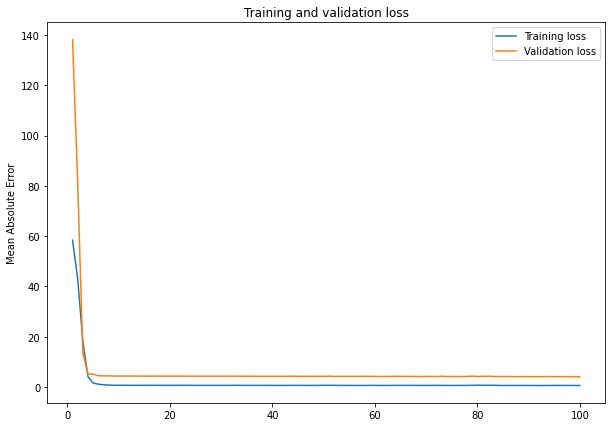

In [95]:
# visualize the loss
loss = lstm_window_8_horizon_3_history.history['loss']
val_loss = lstm_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

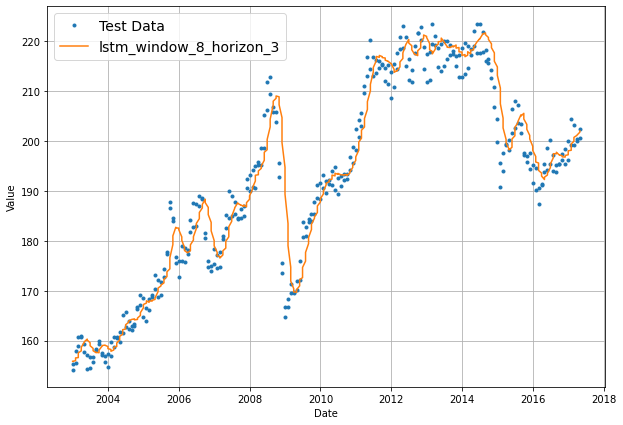

In [96]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(lstm_window_8_horizon_3_preds, axis=1), format='-', label='lstm_window_8_horizon_3')

## LSTM (window=15, horizon=3)

In [97]:
WINDOW = 15
HORIZON = 3

In [98]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1721, 1721)

In [99]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1376, 345, 1376, 345)

In [100]:
lstm_window_15_horizon_3 = make_lstm_model(window_size=WINDOW, horizon_size=HORIZON, model_name='lstm_window_15_horizon_3')

lstm_window_15_horizon_3_history = lstm_window_15_horizon_3.fit(
  train_windows,
  train_labels,
  epochs=100,
  verbose=0,
  batch_size=128,
  validation_data=(test_windows, test_labels),
  callbacks=[create_model_checkpoint(model_name=lstm_window_15_horizon_3.name)]
)

In [101]:
lstm_window_15_horizon_3 = tf.keras.models.load_model("model_checkpoints/lstm_window_15_horizon_3")
lstm_window_15_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 2ms/step - loss: 4.5288


4.528794288635254

In [102]:
lstm_window_15_horizon_3_preds = make_preds(lstm_window_15_horizon_3, test_windows)
lstm_window_15_horizon_3_preds[:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[155.32195, 155.40385, 155.63371],
       [155.34323, 155.59657, 155.71698],
       [155.86751, 156.04472, 156.18108],
       [156.07565, 156.04318, 156.61934],
       [156.63254, 156.80804, 156.92204],
       [157.40114, 157.06427, 157.9931 ],
       [157.65952, 157.87189, 158.23189],
       [158.51799, 158.3536 , 159.03873],
       [158.31175, 158.51166, 159.42189],
       [158.7159 , 159.26874, 158.71046]], dtype=float32)>

In [103]:
lstm_window_15_horizon_3_results = evaluate_preds(
  y_true=tf.squeeze(test_labels),
  y_pred=lstm_window_15_horizon_3_preds
)

lstm_window_15_horizon_3_results

{'mae': 4.5287943,
 'mse': 45.41173,
 'rmse': 4.9051957,
 'mape': 2.3930898,
 'mase': 67.21424}

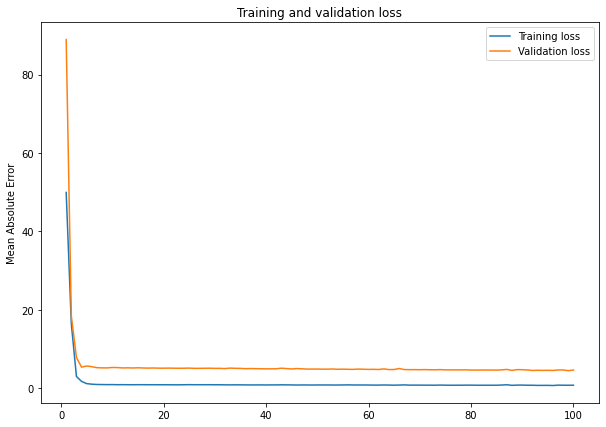

In [104]:
# visualize the loss
loss = lstm_window_15_horizon_3_history.history['loss']
val_loss = lstm_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

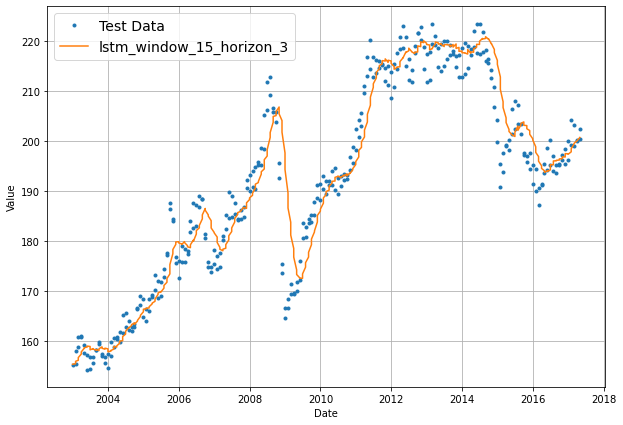

In [105]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(lstm_window_15_horizon_3_preds, axis=1), format='-', label='lstm_window_15_horizon_3')

<AxesSubplot:>

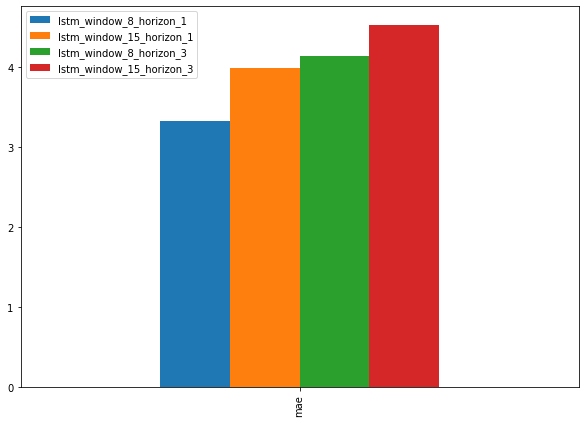

In [106]:
pd.DataFrame({
    'lstm_window_8_horizon_1': lstm_window_8_horizon_1_results['mae'],
    'lstm_window_15_horizon_1': lstm_window_15_horizon_1_results['mae'],
    'lstm_window_8_horizon_3': lstm_window_8_horizon_3_results['mae'],
    'lstm_window_15_horizon_3': lstm_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

# function for creating N-BEATS model with given window and horizon size

In [107]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): 
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs 
    for layer in self.hidden: 
      x = layer(x)
    theta = self.theta_layer(x) 
    
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [108]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

In [109]:
def make_nbeats_model(window_size=8, horizon_size=1, model_name='nbeats'):
    WINDOW = window_size
    HORIZON = horizon_size

    INPUT_SIZE = WINDOW # called "Lookback" in Table 18
    THETA_SIZE = INPUT_SIZE + HORIZON

    tf.random.set_seed(7)
    np.random.seed(7)

    nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                     theta_size=THETA_SIZE,
                                     horizon=HORIZON,
                                     n_neurons=N_NEURONS,
                                     n_layers=N_LAYERS,
                                     name="InitialBlock")

    stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE), name="stack_input")


    backcast, forecast = nbeats_block_layer(stack_input)

    residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00") 

    # 4. Create stacks of blocks
    for i, _ in enumerate(range(N_STACKS-1)):

      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          name=f"NBeatsBlock_{i}"
      )(residuals)

      residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
      forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

    model = tf.keras.Model(inputs=stack_input, 
                             outputs=forecast, 
                             name=model_name)

    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])
    
    return model


## N-Beats (window=8, horizon=1)

In [110]:
WINDOW = 8
HORIZON = 1

In [111]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1730, 1730)

In [112]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1384, 346, 1384, 346)

In [113]:
nbeats_window_8_horizon_1 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_8_horizon_1')

nbeats_window_8_horizon_1_history = nbeats_window_8_horizon_1.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [114]:
nbeats_window_8_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 10ms/step - loss: 2.4106 - mae: 2.4106 - mse: 10.0445


[2.4106333255767822, 2.4106333255767822, 10.044464111328125]

In [115]:
nbeats_window_8_horizon_1_preds = make_preds(nbeats_window_8_horizon_1, test_windows)
nbeats_window_8_horizon_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([155.48927, 157.14516, 157.2966 , 159.0634 , 160.14423],
      dtype=float32)>

In [116]:
nbeats_window_8_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_8_horizon_1_preds
)

nbeats_window_8_horizon_1_results

{'mae': 2.4106333,
 'mse': 10.044463,
 'rmse': 3.1693,
 'mape': 1.2501552,
 'mase': 67.15626}

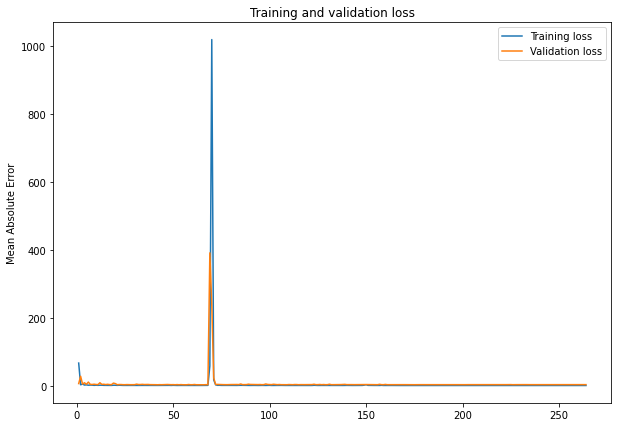

In [117]:
# visualize the loss
loss = nbeats_window_8_horizon_1_history.history['loss']
val_loss = nbeats_window_8_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

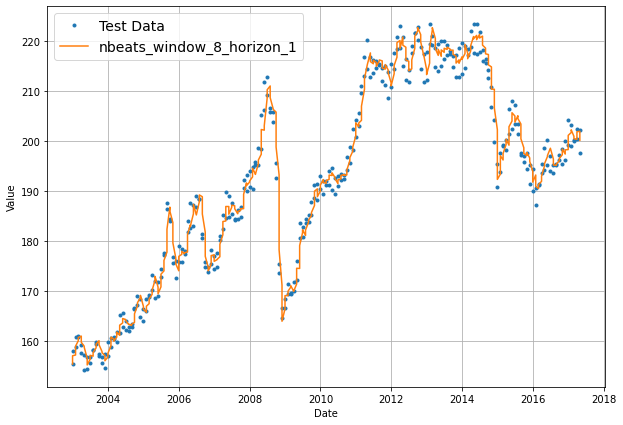

In [118]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=nbeats_window_8_horizon_1_preds, format='-', label='nbeats_window_8_horizon_1')

## N-Beats (window=15, horizon=1)

In [119]:
WINDOW = 15
HORIZON = 1

In [120]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1723, 1723)

In [121]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1378, 345, 1378, 345)

In [122]:
nbeats_window_15_horizon_1 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_15_horizon_1')

nbeats_window_15_horizon_1_history = nbeats_window_15_horizon_1.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00155: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00322: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00422: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [123]:
nbeats_window_15_horizon_1.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 10ms/step - loss: 2.5395 - mae: 2.5395 - mse: 10.2251


[2.539533853530884, 2.539533853530884, 10.225092887878418]

In [124]:
nbeats_window_15_horizon_1_preds = make_preds(nbeats_window_15_horizon_1, test_windows)
nbeats_window_15_horizon_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([157.20384, 156.5429 , 159.32324, 159.66238, 160.40297],
      dtype=float32)>

In [125]:
nbeats_window_15_horizon_1_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_15_horizon_1_preds
)

nbeats_window_15_horizon_1_results

{'mae': 2.5395339,
 'mse': 10.225092,
 'rmse': 3.1976697,
 'mape': 1.311403,
 'mase': 67.16621}

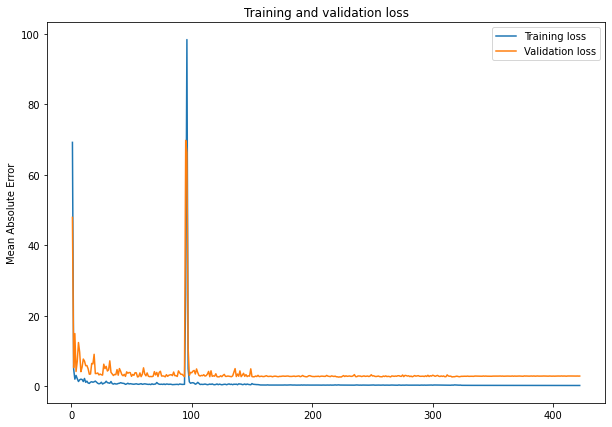

In [126]:
# visualize the loss
loss = nbeats_window_15_horizon_1_history.history['loss']
val_loss = nbeats_window_15_horizon_1_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

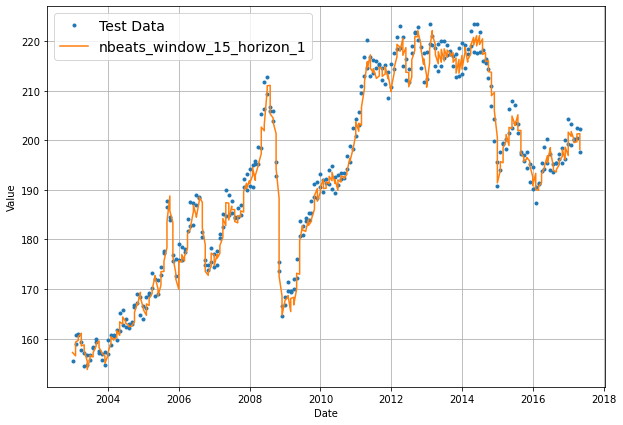

In [127]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=nbeats_window_15_horizon_1_preds, format='-', label='nbeats_window_15_horizon_1')

## N-Beats (window=8, horizon=3)

In [128]:
WINDOW = 8
HORIZON = 3

In [129]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1728, 1728)

In [130]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1382, 346, 1382, 346)

In [131]:
nbeats_window_8_horizon_3 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_8_horizon_3')

nbeats_window_8_horizon_3_history = nbeats_window_8_horizon_3.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00195: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [132]:
nbeats_window_8_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 10ms/step - loss: 2.9570 - mae: 2.9570 - mse: 16.8788


[2.9570038318634033, 2.9570038318634033, 16.878782272338867]

In [133]:
nbeats_window_8_horizon_3_preds = make_preds(nbeats_window_8_horizon_3, test_windows)
nbeats_window_8_horizon_3_preds[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[156.09795, 156.53651, 156.11127],
       [155.3867 , 155.75314, 155.31903],
       [155.50215, 156.09142, 155.65698],
       [157.56828, 158.24438, 157.9641 ],
       [157.26299, 157.40681, 156.90683]], dtype=float32)>

In [134]:
nbeats_window_8_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_8_horizon_3_preds
)

nbeats_window_8_horizon_3_results

{'mae': 2.9570038,
 'mse': 16.878784,
 'rmse': 3.3292184,
 'mape': 1.5453147,
 'mase': 67.22925}

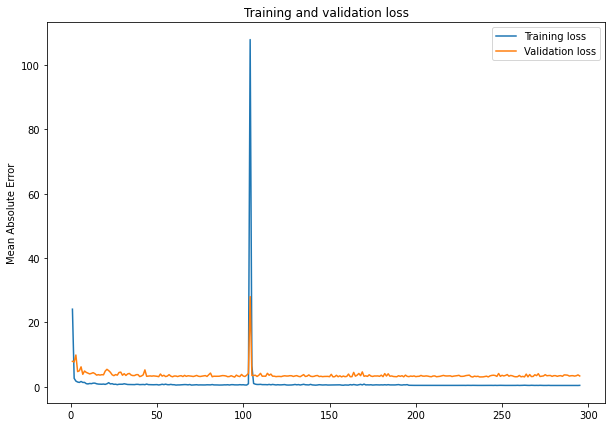

In [135]:
# visualize the loss
loss = nbeats_window_8_horizon_3_history.history['loss']
val_loss = nbeats_window_8_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

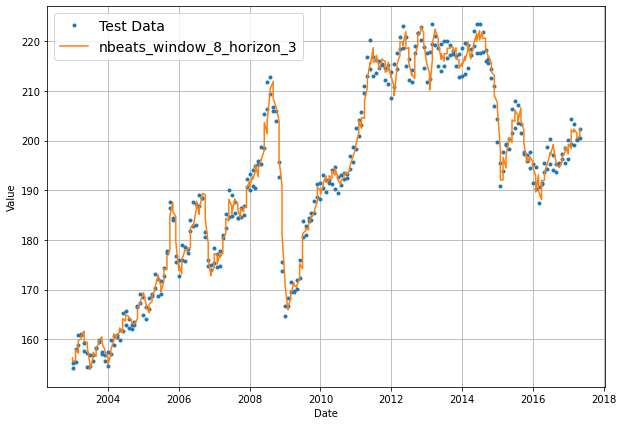

In [136]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(nbeats_window_8_horizon_3_preds, axis=1), format='-', label='nbeats_window_8_horizon_3')

## N-Beats (window=15, horizon=3)

In [137]:
WINDOW = 15
HORIZON = 3

In [138]:
windows, labels = make_windows(values, window_size=WINDOW, horizon=HORIZON)
len(windows), len(labels)

(1721, 1721)

In [139]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=windows, labels=labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1376, 345, 1376, 345)

In [140]:
nbeats_window_15_horizon_3 = make_nbeats_model(window_size=WINDOW, horizon_size=HORIZON, model_name='nbeats_window_15_horizon_3')

nbeats_window_15_horizon_3_history = nbeats_window_15_horizon_3.fit(x=train_windows,
            y=train_labels,
            epochs=N_EPOCHS,
            validation_data=(test_windows, test_labels),
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00422: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00522: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [141]:
nbeats_window_15_horizon_3.evaluate(test_windows, test_labels)

11/11 [==============================] - 0s 10ms/step - loss: 3.0704 - mae: 3.0704 - mse: 18.1004


[3.070375442504883, 3.070375442504883, 18.100385665893555]

In [142]:
nbeats_window_15_horizon_3_preds = make_preds(nbeats_window_15_horizon_3, test_windows)
nbeats_window_15_horizon_3_preds[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[155.20381, 154.4739 , 155.72769],
       [155.652  , 155.0366 , 156.25879],
       [157.78604, 157.33467, 158.61562],
       [156.84207, 156.07773, 157.32285],
       [159.84966, 159.48618, 160.79144]], dtype=float32)>

In [143]:
nbeats_window_15_horizon_3_results = evaluate_preds(
  y_true = tf.squeeze(test_labels),
  y_pred = nbeats_window_15_horizon_3_preds
)

nbeats_window_15_horizon_3_results

{'mae': 3.0703752,
 'mse': 18.100388,
 'rmse': 3.4447234,
 'mape': 1.6063854,
 'mase': 67.21424}

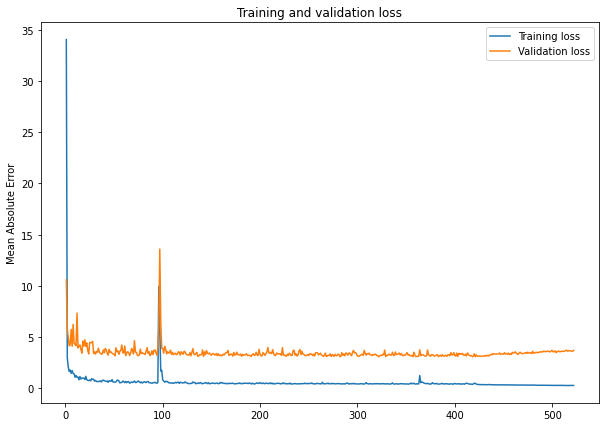

In [144]:
# visualize the loss
loss = nbeats_window_15_horizon_3_history.history['loss']
val_loss = nbeats_window_15_horizon_3_history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,7))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

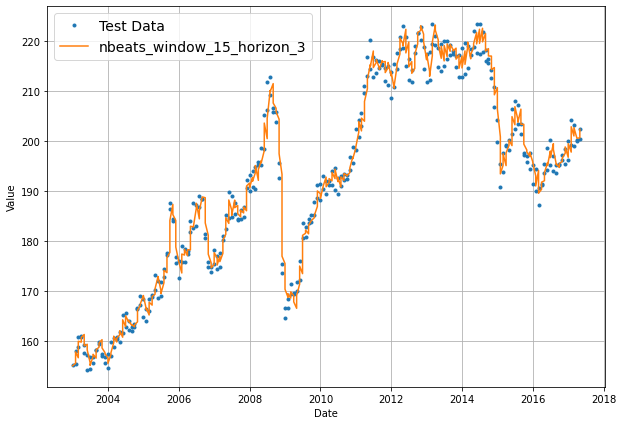

In [145]:
# visualize the predictions
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(nbeats_window_15_horizon_3_preds, axis=1), format='-', label='nbeats_window_15_horizon_3')

<AxesSubplot:>

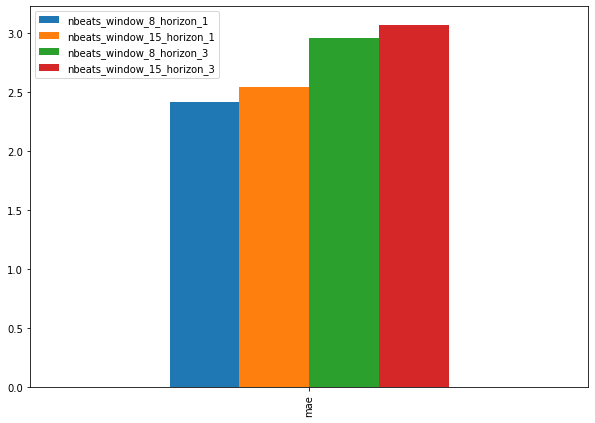

In [146]:
pd.DataFrame({
    'nbeats_window_8_horizon_1':nbeats_window_8_horizon_1_results['mae'],
    'nbeats_window_15_horizon_1': nbeats_window_15_horizon_1_results['mae'],
    'nbeats_window_8_horizon_3': nbeats_window_8_horizon_3_results['mae'],
    'nbeats_window_15_horizon_3': nbeats_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

# Plots comparing different models with same window and horizon sizes

## Window = 8, Horizon = 1

<AxesSubplot:>

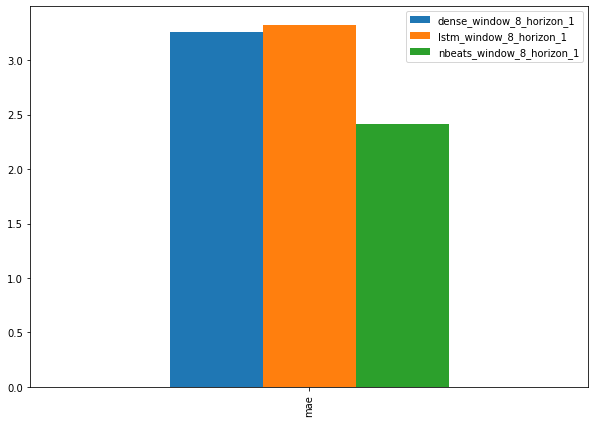

In [147]:
pd.DataFrame({
    'dense_window_8_horizon_1':dense_window_8_horizon_1_results['mae'],
    'lstm_window_8_horizon_1': lstm_window_8_horizon_1_results['mae'],
    'nbeats_window_8_horizon_1': nbeats_window_8_horizon_1_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 15, Horizon = 1

<AxesSubplot:>

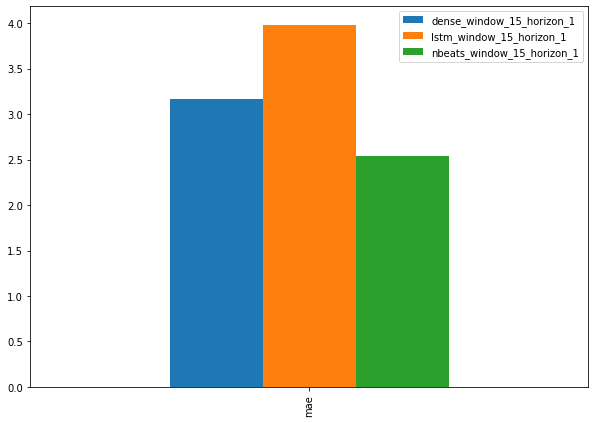

In [148]:
pd.DataFrame({
    'dense_window_15_horizon_1':dense_window_15_horizon_1_results['mae'],
    'lstm_window_15_horizon_1': lstm_window_15_horizon_1_results['mae'],
    'nbeats_window_15_horizon_1': nbeats_window_15_horizon_1_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 8, Horizon = 3

<AxesSubplot:>

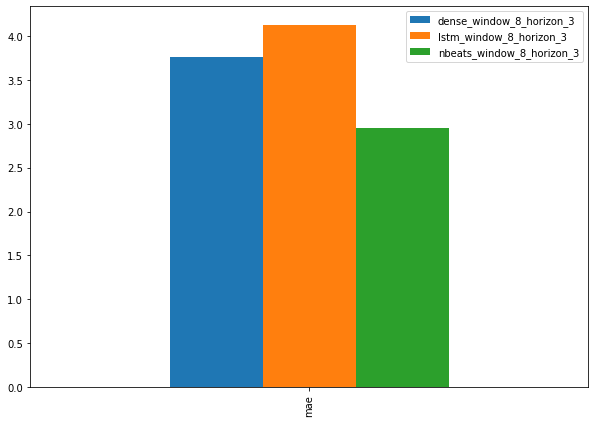

In [149]:
pd.DataFrame({
    'dense_window_8_horizon_3':dense_window_8_horizon_3_results['mae'],
    'lstm_window_8_horizon_3': lstm_window_8_horizon_3_results['mae'],
    'nbeats_window_8_horizon_3': nbeats_window_8_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')

## Window = 15, Horizon = 3

<AxesSubplot:>

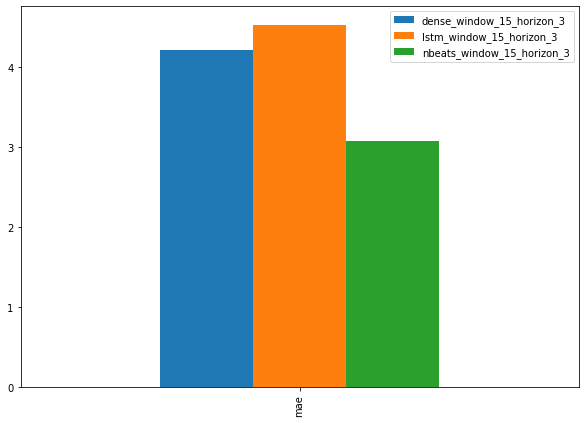

In [150]:
pd.DataFrame({
    'dense_window_15_horizon_3':dense_window_15_horizon_3_results['mae'],
    'lstm_window_15_horizon_3': lstm_window_15_horizon_3_results['mae'],
    'nbeats_window_15_horizon_3': nbeats_window_15_horizon_3_results['mae']}, index=['mae']).plot(figsize=(10,7), kind='bar')